# Telco Churn Predictions

### Question: Why are customers churning? 

### Goals: Predict which customers are going to churn and what features are causing churn.
(Baseline of 60% churn***)

### Additional questons:
- Could the month in which they sign up influence churn?
- If a cohort(s) is identified by tenure, is there a cohort who has a higher rate of churn than others?
- Are there features that indicate a higher rate of churn?
- Is there a price threshhold for specific services where likihood of churn increases once customers get past that point? What is that price point and for what services?
- Are the rates comparable for customers who have month-to-month contracts at the 12-month mark vs the customers who have 1-year contracts at their 12-month mark?

### Data Dictionary

Choices made and why
what columns mean
combined columns and why
dropped columns and why
changed dtypes

## Imports

- Import all the neccessary libraries needed to create models that will predict churn.

In [63]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.ensemble import RandomForestClassifier

from util import get_db_url
import acquire
import prepare
import feature_selection

- I will use the acquire.py file to get the data. I will look through the data in this notebook and clean up anything that I feel needs to be cleande up: fill or drop null values, change data types, etc.

**Tasks: check for nulls, look at dtypes, handle customer_id column.**

In [2]:
df = acquire.acquire_telco()
df.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.40,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.10,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.50,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [3]:
df.shape

(7032, 24)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7032 non-null int64
internet_service_type_id    7032 non-null int64
contract_type_id            7032 non-null int64
customer_id                 7032 non-null object
gender                      7032 non-null object
senior_citizen              7032 non-null int64
partner                     7032 non-null object
dependents                  7032 non-null object
tenure                      7032 non-null int64
phone_service               7032 non-null object
multiple_lines              7032 non-null object
online_security             7032 non-null object
online_backup               7032 non-null object
device_protection           7032 non-null object
tech_support                7032 non-null object
streaming_tv                7032 non-null object
streaming_movies            7032 non-null object
paperless_billing           7032 non-null object
monthly_charges 

**From looking at this table:**
- Change total_charges column into float.
- Change churn column into numeric values to run through a model.

In [5]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
payment_type_id,7032.0,2.315557,1.149523,1.00,1.0000,2.000,3.0000,4.00
internet_service_type_id,7032.0,1.872582,0.737271,1.00,1.0000,2.000,2.0000,3.00
contract_type_id,7032.0,1.688567,0.832934,1.00,1.0000,1.000,2.0000,3.00
senior_citizen,7032.0,0.162400,0.368844,0.00,0.0000,0.000,0.0000,1.00
tenure,7032.0,32.421786,24.545260,1.00,9.0000,29.000,55.0000,72.00
monthly_charges,7032.0,64.798208,30.085974,18.25,35.5875,70.350,89.8625,118.75
total_charges,7032.0,2283.300441,2266.771362,18.80,401.4500,1397.475,3794.7375,8684.80


- Check the data for any null values using .value_counts().

In [6]:
df.churn.value_counts()

No     5163
Yes    1869
Name: churn, dtype: int64

In [7]:
df.monthly_charges.value_counts()
df.monthly_charges.isnull().sum()

0

- Looking at the .value_counts() for total charges, I saw that there were 11 null values, so I went in and took care of those empty values by turning them into np.nan's, then double checked the work.

In [8]:
df.total_charges.value_counts()
df.total_charges.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df.total_charges.value_counts(dropna=False)

20.20      11
19.75       9
20.05       8
19.90       8
19.65       8
19.55       7
45.30       7
20.15       6
20.25       6
19.45       6
20.45       5
20.30       5
69.65       4
69.90       4
19.40       4
70.60       4
20.50       4
20.40       4
19.50       4
49.90       4
69.95       4
19.95       4
19.30       4
75.30       4
44.00       4
19.20       4
19.85       4
74.70       4
50.15       4
69.60       4
           ..
1834.15     1
999.80      1
8333.95     1
7171.70     1
3726.15     1
80.05       1
456.85      1
96.05       1
1399.35     1
2497.35     1
7069.30     1
688.65      1
6471.85     1
552.10      1
3242.50     1
3252.00     1
183.75      1
6886.25     1
7108.20     1
78.45       1
1171.30     1
3181.80     1
2540.10     1
3580.95     1
6470.10     1
3143.65     1
1110.50     1
1098.85     1
156.10      1
30.50       1
Name: total_charges, Length: 6530, dtype: int64

- Since there were only 11 np.nan values in the total charges, I opted to just drop the 11 rows from the dataframe, since I am working with over 7,000 rows.

In [9]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7042
Data columns (total 24 columns):
payment_type_id             7032 non-null int64
internet_service_type_id    7032 non-null int64
contract_type_id            7032 non-null int64
customer_id                 7032 non-null object
gender                      7032 non-null object
senior_citizen              7032 non-null int64
partner                     7032 non-null object
dependents                  7032 non-null object
tenure                      7032 non-null int64
phone_service               7032 non-null object
multiple_lines              7032 non-null object
online_security             7032 non-null object
online_backup               7032 non-null object
device_protection           7032 non-null object
tech_support                7032 non-null object
streaming_tv                7032 non-null object
streaming_movies            7032 non-null object
paperless_billing           7032 non-null object
monthly_charges 

- I will now change the total_charges from an object to a float, since it is money.

In [10]:
df.total_charges.dtype
df['total_charges'] = df['total_charges'].astype(float)
df.total_charges.dtype

dtype('float64')

**Task: Look into customer_id column.**

## Baseline Model: Decision Tree

- After preparing the data, I will create a new baseline dataframe and pick random numeric features to create a baseline model to predict churn. In order to do this, I need need to encode my churn column into 0's and 1's to depict either churned or not churned.

**Task: Encode churn column.**

In [11]:
df_base = df
df_base.head()

,payment_type_id,internet_service_type_id,contract_type_id,customer_id,gender,senior_citizen,partner,dependents,tenure,phone_service,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
0,2,1,1,0003-MKNFE,Male,0,No,No,9,Yes,...,No,No,Yes,No,59.9,542.40,No,Month-to-month,DSL,Mailed check
1,4,1,1,0013-MHZWF,Female,0,No,Yes,9,Yes,...,Yes,Yes,Yes,Yes,69.4,571.45,No,Month-to-month,DSL,Credit card (automatic)
2,1,1,1,0015-UOCOJ,Female,1,No,No,7,Yes,...,No,No,No,Yes,48.2,340.35,No,Month-to-month,DSL,Electronic check
3,1,1,1,0023-HGHWL,Male,1,No,No,1,No,...,No,No,No,Yes,25.1,25.10,Yes,Month-to-month,DSL,Electronic check
4,3,1,1,0032-PGELS,Female,0,Yes,Yes,1,No,...,No,No,No,No,30.5,30.50,Yes,Month-to-month,DSL,Bank transfer (automatic)


In [12]:
base_encoder = LabelEncoder()
df_base.churn = base_encoder.fit_transform(df_base.churn)
df_base.churn.head()

0    0
1    0
2    0
3    1
4    1
Name: churn, dtype: int64

- The dtype for the churn column has now been changed from object to an integer.

In [13]:
df_base.churn.dtype

dtype('int64')

- I will define what columns I want to be my features (X) and churn as my target (y).

In [14]:
X = df_base[['tenure', 'monthly_charges', 'total_charges']]
y = df_base[['churn']]

- I will split the data into train and test, and then run the data through a decision tree model to create a baseline model.
- After I plug the data into the model, I will look at the predicted churn values, and the probabilities of the customer either churning or not churning.

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=.7, random_state=123)

In [16]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)
clf.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [17]:
y_pred = clf.predict(X_train)
y_pred

array([1, 0, 0, ..., 0, 0, 1])

In [18]:
y_pred_proba = clf.predict_proba(X_train)
y_pred_proba

array([[0.36346516, 0.63653484],
       [0.91964286, 0.08035714],
       [0.87067395, 0.12932605],
       ...,
       [0.87067395, 0.12932605],
       [0.63268156, 0.36731844],
       [0.36346516, 0.63653484]])

#### Evaluate the Baseline Model

In [19]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X_train, y_train)))

Accuracy of Decision Tree classifier on training set: 0.79


In [20]:
confusion_matrix(y_train, y_pred)

array([[3298,  327],
       [ 684,  613]])

In [21]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.87      3625
           1       0.65      0.47      0.55      1297

    accuracy                           0.79      4922
   macro avg       0.74      0.69      0.71      4922
weighted avg       0.78      0.79      0.78      4922



In [22]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.79


### Takeaways:
- The accuracy score for the data chosen to run through this model is 84%. This baseline is better than the firt baseline, 60%.

**Tasks: Create a new model with more/different features, encoded data and scaled data.**

## Baseline Model 2: Decision Tree using Encoded Data

- I will create a new dataframe with the cleaned up data and then encode the dtypes that are objects to turn them into numeric values to have more features to run through a model. I will set the customer id column as the index, to move it to the side, but keep it for reference.

**Task: Encode features run through a new model.**

In [23]:
df_telco = df
df_telco.set_index('customer_id', inplace=True)
df_telco.head()

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,...,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn,contract_type,internet_service_type,payment_type
customer_id,,,,,,,,,,,,,,,,,,,,,
0003-MKNFE,2,1,1,Male,0,No,No,9,Yes,Yes,...,No,No,Yes,No,59.9,542.40,0,Month-to-month,DSL,Mailed check
0013-MHZWF,4,1,1,Female,0,No,Yes,9,Yes,No,...,Yes,Yes,Yes,Yes,69.4,571.45,0,Month-to-month,DSL,Credit card (automatic)
0015-UOCOJ,1,1,1,Female,1,No,No,7,Yes,No,...,No,No,No,Yes,48.2,340.35,0,Month-to-month,DSL,Electronic check
0023-HGHWL,1,1,1,Male,1,No,No,1,No,No phone service,...,No,No,No,Yes,25.1,25.10,1,Month-to-month,DSL,Electronic check
0032-PGELS,3,1,1,Female,0,Yes,Yes,1,No,No phone service,...,No,No,No,No,30.5,30.50,1,Month-to-month,DSL,Bank transfer (automatic)


In [24]:
# df_telco['family'] = (df.partner == True) | (df.dependents == True)
# df_telco.head()

- I will encode all columns that make sense for me to change with a Label Encoder in order to run more features through a model.
- I will also drop the columns contract typem internet service type and payment type, since they are repeats of the type id columns.

**Task: Establish what each number corresponds to after encoding the columns.**

In [25]:
train, test = train_test_split(df, train_size=.7, random_state=123)
print('Train data shape:', train.shape)
print('Test data shape:', test.shape)

Train data shape: (4922, 23)
Test data shape: (2110, 23)


In [26]:
def encode(train, test):
    encoder = LabelEncoder()
    train = train.drop(columns=['contract_type', 'internet_service_type','payment_type'])
    test = test.drop(columns=['contract_type', 'internet_service_type', 'payment_type'])
    encode_list = ['gender','partner', 'dependents', 'phone_service','multiple_lines', 'online_security', 'online_backup','device_protection','tech_support','streaming_tv', \
                  'streaming_movies', 'paperless_billing', 'churn']
    for c in encode_list:
        train[c] = encoder.fit_transform(train[c])
        test[c] = encoder.transform(test[c])
    return train, test

In [27]:
train_encode, test_encode = encode(train, test)
train_encode.head()

,payment_type_id,internet_service_type_id,contract_type_id,gender,senior_citizen,partner,dependents,tenure,phone_service,multiple_lines,online_security,online_backup,device_protection,tech_support,streaming_tv,streaming_movies,paperless_billing,monthly_charges,total_charges,churn
customer_id,,,,,,,,,,,,,,,,,,,,
3866-MDTUB,1,1,1,0,0,0,0,2,1,0,2,0,0,0,2,2,1,70.75,146.90,1
5555-RNPGT,4,3,1,1,0,0,1,10,1,2,1,1,1,1,1,1,0,24.80,223.90,0
3727-OWVYD,2,1,2,1,0,0,0,35,1,0,2,2,2,0,0,0,0,61.20,2021.20,0
2270-CHBFN,4,2,1,0,0,1,0,44,1,2,2,2,2,2,0,0,1,95.10,4060.55,0
6892-XPFPU,1,2,1,1,1,1,0,24,1,2,0,2,2,0,2,2,1,104.25,2433.90,1


In [28]:
X = train_encode.drop(['churn'],axis=1)
y = train_encode[['churn']]
X_test = test_encode.drop(['churn'],axis=1)
y_test = test_encode[['churn']]

In [29]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=4, random_state=123)
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [30]:
y_pred = clf.predict(X)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [31]:
y_pred_proba = clf.predict_proba(X)
y_pred_proba

array([[0.82075472, 0.17924528],
       [0.82075472, 0.17924528],
       [0.9       , 0.1       ],
       ...,
       [0.9       , 0.1       ],
       [0.82075472, 0.17924528],
       [0.51969504, 0.48030496]])

#### Evaluate Baseline Model 2

In [32]:
print('Accuracy of Decision Tree classifier on training set: {:.2f}'
     .format(clf.score(X, y)))

Accuracy of Decision Tree classifier on training set: 0.79


In [33]:
print(confusion_matrix(y, y_pred))

[[3368  257]
 [ 776  521]]


In [34]:
print(classification_report(y, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.87      3625
           1       0.67      0.40      0.50      1297

    accuracy                           0.79      4922
   macro avg       0.74      0.67      0.68      4922
weighted avg       0.78      0.79      0.77      4922



In [35]:
print('Accuracy of Decision Tree classifier on test set: {:.2f}'
     .format(clf.score(X_test, y_test)))

Accuracy of Decision Tree classifier on test set: 0.77


### Takeaways:
- The accuracy of this model is extremely similar to the the accuracy of the first baseline model I ran, with only three features. I will continue with this baseline model 2 moving forward in order to work with more features.

## Exploratory Analysis

- Using the encoded data, I will now look at the correlation between all features to then find the best features to use in my predictive model.

- I will begin by looking at the distribution of churn.

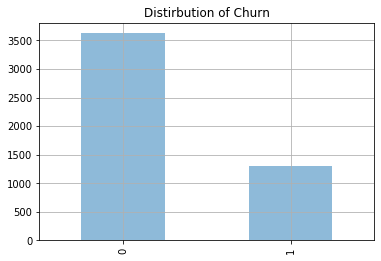

In [36]:
y.churn.value_counts().sort_index().plot(kind = "bar",alpha = .5)
plt.title("Distirbution of Churn")
plt.grid(b = True , which = "major")

- Takeaway: Significantly less people have churned (1) vs. people who have not churned (0).

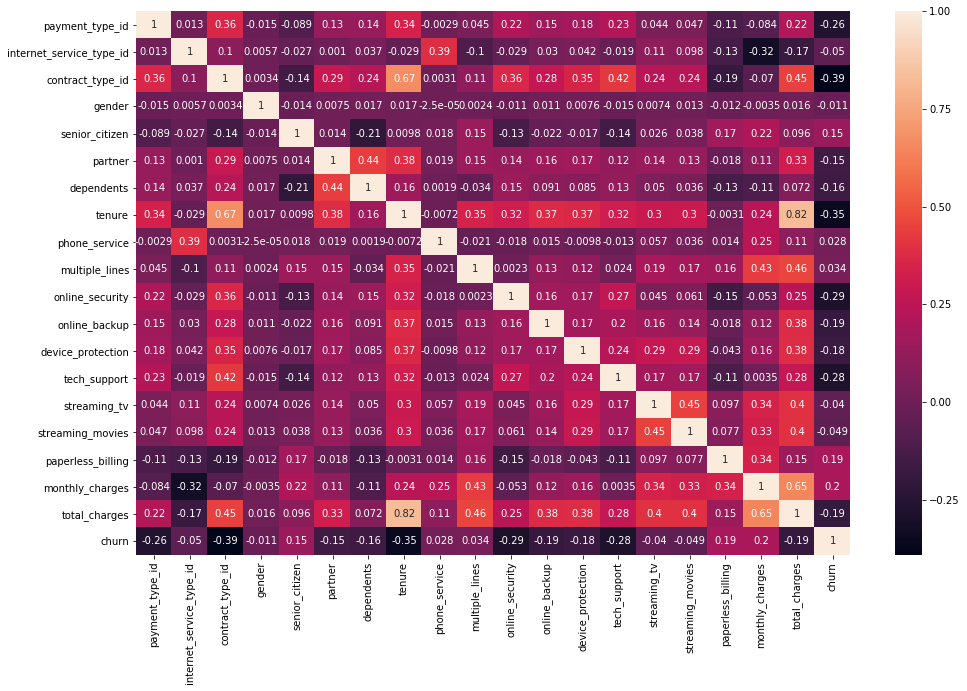

In [37]:
plt.figure(figsize=(16,10))
sns.heatmap(train_encode.corr(), annot=True)

- Takeaway: This heatmap allows me to get a better idea of how features are correlated to each other.
- total charges and tenure
- tenure and contract id type
- monthly charges and total charges

#### Question 1: Could the month in which they sign up influence churn?

In [38]:
pd.crosstab(y.churn, X.tenure, margins=True).style.background_gradient(cmap='YlOrRd')

tenure,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,All
churn,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,146,90,78,66,47,45,55,65,46,49,49,56,45,36,46,36,44,43,34,38,31,47,49,46,48,48,42,29,43,45,36,33,39,38,59,24,38,33,23,39,42,36,33,29,42,42,39,44,38,43,40,54,42,41,37,50,39,41,35,48,44,48,38,50,42,52,62,64,64,76,116,250,3625
1,267,88,59,63,44,24,34,29,28,34,22,29,26,15,23,13,15,14,14,13,13,17,7,16,16,11,7,8,13,14,12,13,9,8,12,8,8,10,9,10,9,10,12,4,5,10,11,7,13,7,8,6,9,10,6,6,5,11,6,4,6,3,4,3,4,8,9,7,4,8,4,3,1297
All,413,178,137,129,91,69,89,94,74,83,71,85,71,51,69,49,59,57,48,51,44,64,56,62,64,59,49,37,56,59,48,46,48,46,71,32,46,43,32,49,51,46,45,33,47,52,50,51,51,50,48,60,51,51,43,56,44,52,41,52,50,51,42,53,46,60,71,71,68,84,120,253,4922


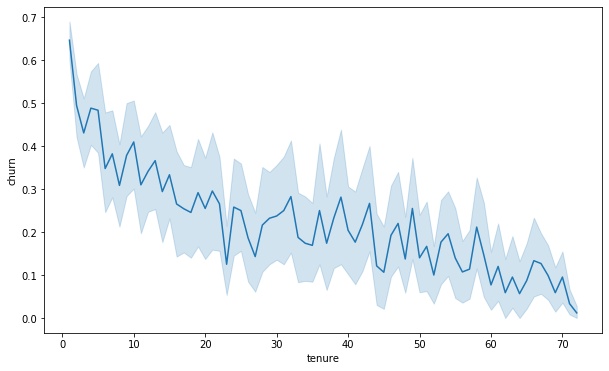

In [43]:
plt.figure(figsize=(10,6))
sns.lineplot(x='tenure', y='churn', data=train_encode)

Takeaway: The longer a customer's tenure, the less likely they churn. This is probably due to different contract types. I will now look into this to get a better sense of contract type compared to churn rate.

#### Question 2: If a cohort(s) is identified by tenure, is there a cohort who has a higher rate of churn than others?

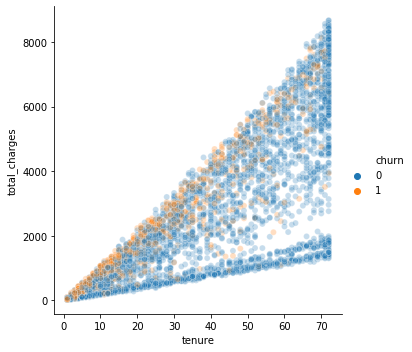

In [40]:
sns.relplot(x='tenure', y='total_charges', hue='churn', data=train_encode, alpha=.25)

Takeaway: You can see from this chart that more people tend to churn when their tenure is less than those with a larger tenure. This can be due to many different variables. I will look at more features independently to see if there is a correlation for those who have churned.

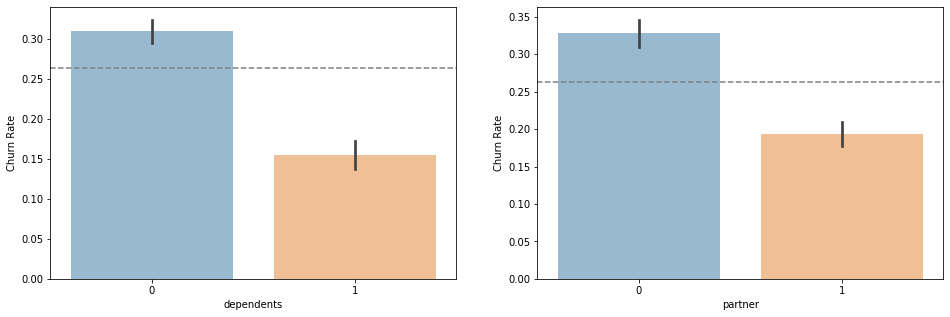

In [41]:
features = ['dependents', 'partner']

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,5))

churn_rate = train_encode.churn.mean()

for i, feature in enumerate(features):
    sns.barplot(feature, 'churn', data=train_encode, ax=ax[i], alpha=.5)
    ax[i].set_ylabel('Churn Rate')
    ax[i].axhline(churn_rate, ls='--', color='grey')

Melt these columns, partner and dependents, into one column, since they are extremely similar.

#### Question 3: Are there features that indicate a higher rate of churn?

#### Question 4: Is there a price threshhold for specific services where likihood of churn increase once customers get past that point? What is that price point and for what services?

#### Question 5: Are the rates comparable for customers who have month-to-month contracts ath their 12-month mark vs. the customers who have a 1-year contract at their 12-month mark?

## MVP Model: Logistic Regression

- Use SelectKBest to select the best features to use in my model to predict churn.

In [42]:
f_selector = SelectKBest(f_regression, k=4)

f_selector.fit(X, y)

f_support = f_selector.get_support()
f_feature = X.loc[:,f_support].columns.tolist()

print(str(len(f_feature)), 'selected features')
print(f_feature)

4 selected features
['contract_type_id', 'tenure', 'online_security', 'tech_support']


In [47]:
X_kbest = train_encode[['contract_type_id', 'tenure', 'online_security', 'tech_support']]
y_kbest = train_encode[['churn']]

In [57]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=3, random_state=123)
clf.fit(X_kbest, y_kbest)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=123, splitter='best')

In [58]:
y_pred = clf.predict(X_kbest)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [59]:
y_pred_proba = clf.predict_proba(X_kbest)
y_pred_proba

array([[0.67567568, 0.32432432],
       [0.81422925, 0.18577075],
       [0.92319749, 0.07680251],
       ...,
       [0.92319749, 0.07680251],
       [0.67567568, 0.32432432],
       [0.59392265, 0.40607735]])

Evaluate the model

In [60]:
format(clf.score(X_kbest, y_kbest))

'0.785453067858594'

In [61]:
print(classification_report(y_kbest, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.93      0.86      3625
           1       0.67      0.37      0.48      1297

    accuracy                           0.79      4922
   macro avg       0.74      0.65      0.67      4922
weighted avg       0.77      0.79      0.76      4922



In [64]:
rf = RandomForestClassifier(bootstrap=True, 
                            class_weight=None, 
                            criterion='gini',
                            min_samples_leaf=3,
                            n_estimators=10,
                            max_depth=3, 
                            random_state=123)

In [65]:
rf.fit(X_kbest, y_kbest)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=3, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=123,
                       verbose=0, warm_start=False)

In [66]:
print(rf.feature_importances_)

[0.47536214 0.11818429 0.20330859 0.20314498]


In [68]:
y_pred = rf.predict(X_kbest)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [70]:
y_pred_proba = rf.predict_proba(X_kbest)
y_pred_proba

array([[0.62616318, 0.37383682],
       [0.77823657, 0.22176343],
       [0.89945484, 0.10054516],
       ...,
       [0.91651023, 0.08348977],
       [0.71329247, 0.28670753],
       [0.53491407, 0.46508593]])

In [71]:
format(rf.score(X_kbest, y_kbest))

'0.7838277123120683'

In [72]:
print(classification_report(y_kbest, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.95      0.87      3625
           1       0.70      0.32      0.44      1297

    accuracy                           0.78      4922
   macro avg       0.75      0.63      0.65      4922
weighted avg       0.77      0.78      0.75      4922

